In [1]:
############################################################
# STEP 1: SETUP – Tools importieren
############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set_palette("Set2")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print("✓ Tools imported")
print("✓ Ready for bias analysis + training prep")

✓ Tools imported
✓ Ready for bias analysis + training prep


In [3]:
############################################################
# NOTEBOOK: Bias entdecken + Training vorbereiten (REAL DATA)
# Dataset: Heart-disease-dataset.xlsx
############################################################

############################################################
# STEP 2: REAL DATA LADEN (Excel)
############################################################

# Datei anpassen, falls dein Name/Ort anders ist
FILE_PATH = "Heart-disease-dataset.xlsx"

df = pd.read_excel(FILE_PATH)

print("✓ File loaded")
print("Shape:", df.shape)
display(df.head())


✓ File loaded
Shape: (20, 11)


,Patient ID,Age,Gender,Ethnicity,Cholesterol (mg/dL),Blood Pressure (mmHg),BMI,Smoking,Family History,Hospital Site,Diagnosis (Heart Disease: Yes/No)
0,P1,68,Male,White,250,150/95,30,Yes,Yes,A,Yes
1,P2,72,Male,White,260,155/100,29,Yes,Yes,A,Yes
2,P3,65,Male,White,240,148/92,28,No,Yes,A,Yes
3,P4,59,Male,White,215,142/88,27,No,Yes,A,No
4,P5,55,Female,White,195,135/85,25,No,No,A,No


In [4]:

############################################################
# STEP 3: DATASET-STRUKTUR + QUALITY CHECKS
############################################################

print("\n=== DATASET OVERVIEW ===")
print("Rows:", len(df))
print("Columns:", len(df.columns))
print("\nColumns:")
for c in df.columns:
    print("-", c)

print("\n=== TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ No missing values")




=== DATASET OVERVIEW ===
Rows: 20
Columns: 11

Columns:
- Patient ID
- Age
- Gender
- Ethnicity
- Cholesterol (mg/dL)
- Blood Pressure (mmHg)
- BMI
- Smoking
- Family History
- Hospital Site
- Diagnosis (Heart Disease: Yes/No)

=== TYPES ===
Patient ID                           object
Age                                   int64
Gender                               object
Ethnicity                            object
Cholesterol (mg/dL)                  object
Blood Pressure (mmHg)                object
BMI                                   int64
Smoking                              object
Family History                       object
Hospital Site                        object
Diagnosis (Heart Disease: Yes/No)    object
dtype: object

=== MISSING VALUES ===
✓ No missing values


In [5]:

############################################################
# STEP 4: CLEANING & FEATURE ENGINEERING
############################################################
# Ziel: aus Excel-Spalten saubere Modell-Features machen

df_clean = df.copy()

# 1) Cholesterol numeric machen (falls als string)
def to_numeric_safe(x):
    if pd.isna(x):
        return np.nan
    # extrahiere Ziffern
    m = re.findall(r"\d+", str(x))
    return float(m[0]) if m else np.nan

df_clean["Cholesterol_mgdl"] = df_clean["Cholesterol (mg/dL)"].apply(to_numeric_safe)

# 2) Blood Pressure "150/95" → Systolic/Diastolic
def split_bp(bp):
    if pd.isna(bp):
        return (np.nan, np.nan)
    s = str(bp)
    if "/" not in s:
        return (np.nan, np.nan)
    parts = s.split("/")
    try:
        return (float(parts[0]), float(parts[1]))
    except:
        return (np.nan, np.nan)

df_clean["BP_Systolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[0])
df_clean["BP_Diastolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[1])

# 3) Target label: "Diagnosis (Heart Disease: Yes/No)" → 1/0
target_col = "Diagnosis (Heart Disease: Yes/No)"
df_clean["HeartDiseaseLabel"] = df_clean[target_col].map({"Yes": 1, "No": 0})

# 4) Small standard cleanup: strings normalisieren
for col in ["Gender", "Ethnicity", "Smoking", "Family History", "Hospital Site"]:
    df_clean[col] = df_clean[col].astype(str).str.strip()

# 5) AgeGroups (für Bias Checks)
def age_group(age):
    if age < 30:
        return "18-29"
    elif age < 45:
        return "30-44"
    elif age < 65:
        return "45-64"
    else:
        return "65+"

df_clean["AgeGroup"] = df_clean["Age"].apply(age_group)

print("✓ Cleaning done")
display(df_clean.head())


✓ Cleaning done


,Patient ID,Age,Gender,Ethnicity,Cholesterol (mg/dL),Blood Pressure (mmHg),BMI,Smoking,Family History,Hospital Site,Diagnosis (Heart Disease: Yes/No),Cholesterol_mgdl,BP_Systolic,BP_Diastolic,HeartDiseaseLabel,AgeGroup
0,P1,68,Male,White,250,150/95,30,Yes,Yes,A,Yes,250.0,150.0,95.0,1,65+
1,P2,72,Male,White,260,155/100,29,Yes,Yes,A,Yes,260.0,155.0,100.0,1,65+
2,P3,65,Male,White,240,148/92,28,No,Yes,A,Yes,240.0,148.0,92.0,1,65+
3,P4,59,Male,White,215,142/88,27,No,Yes,A,No,215.0,142.0,88.0,0,45-64
4,P5,55,Female,White,195,135/85,25,No,No,A,No,195.0,135.0,85.0,0,45-64



=== GENDER ===


,Count,Percentage
Gender,,
Male,10,50.0
Female,10,50.0


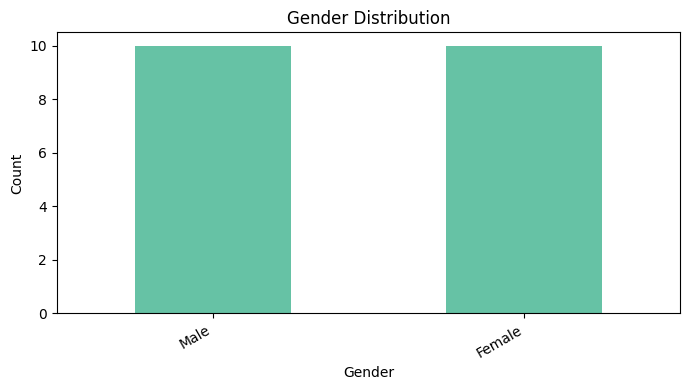


=== ETHNICITY ===


,Count,Percentage
Ethnicity,,
White,6,30.0
Black,5,25.0
Asian,5,25.0
Hispanic,4,20.0


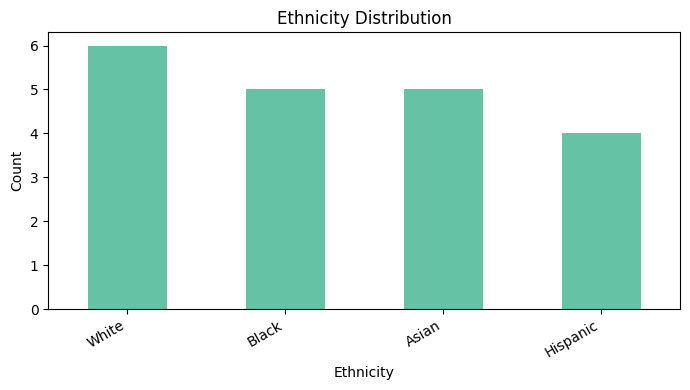


=== HOSPITAL SITE ===


,Count,Percentage
Hospital Site,,
B,9,45.0
A,6,30.0
C,5,25.0


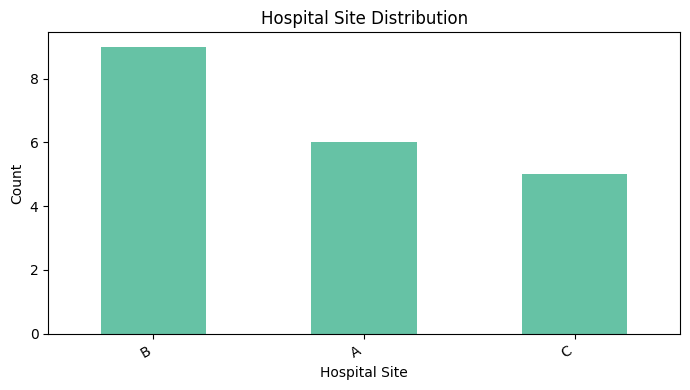


=== AGE GROUP ===


,Count,Percentage
AgeGroup,,
45-64,13,65.0
65+,5,25.0
30-44,2,10.0


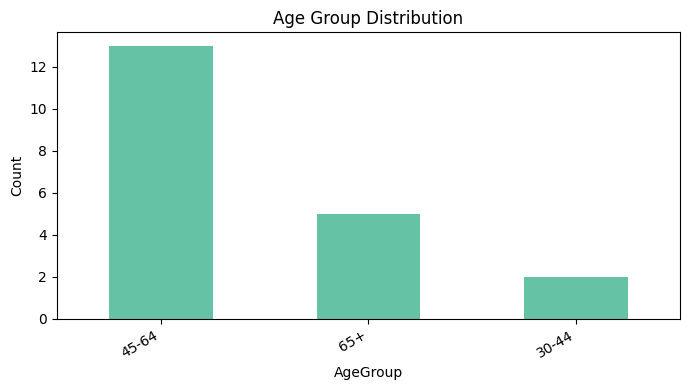

In [6]:


############################################################
# STEP 5: DEMOGRAPHIC REPRESENTATION (Bias-Risiko: Coverage)
############################################################

def analyze_representation(data, column_name, title):
    print(f"\n=== {title.upper()} ===")
    counts = data[column_name].value_counts(dropna=False)
    perc = data[column_name].value_counts(normalize=True, dropna=False) * 100

    rep = pd.DataFrame({"Count": counts, "Percentage": perc.round(1)})
    display(rep)

    plt.figure(figsize=(7,4))
    counts.plot(kind="bar")
    plt.title(f"{title} Distribution")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    return rep

gender_rep = analyze_representation(df_clean, "Gender", "Gender")
eth_rep = analyze_representation(df_clean, "Ethnicity", "Ethnicity")
hospital_rep = analyze_representation(df_clean, "Hospital Site", "Hospital Site")
age_rep = analyze_representation(df_clean, "AgeGroup", "Age Group")




=== LABEL RATE BY GENDER ===


,No (%),Yes (%)
Gender,,
Female,90.0,10.0
Male,20.0,80.0


Difference (max-min Yes%): 70.0 percentage points


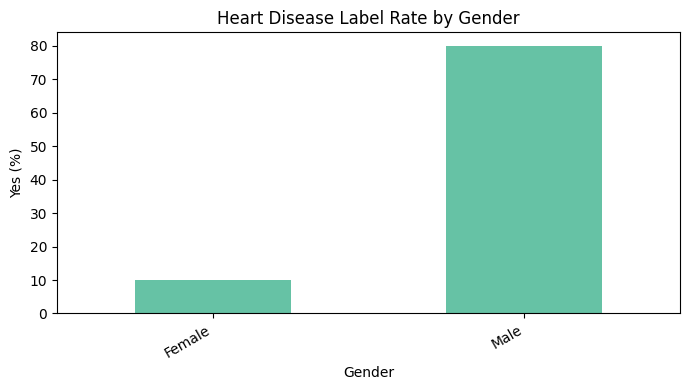


=== LABEL RATE BY ETHNICITY ===


,No (%),Yes (%)
Ethnicity,,
Asian,60.0,40.0
Black,80.0,20.0
Hispanic,25.0,75.0
White,50.0,50.0


Difference (max-min Yes%): 55.0 percentage points


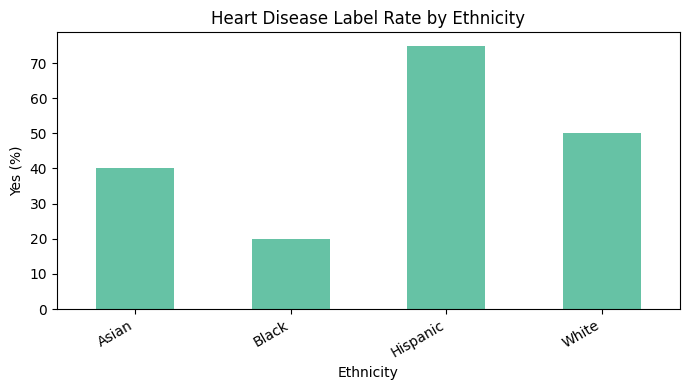


=== LABEL RATE BY HOSPITAL SITE ===


,No (%),Yes (%)
Hospital Site,,
A,50.0,50.0
B,55.6,44.4
C,60.0,40.0


Difference (max-min Yes%): 10.0 percentage points


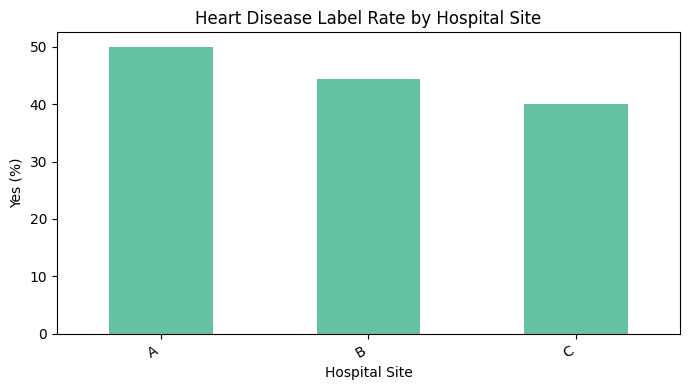


=== LABEL RATE BY AGEGROUP ===


,No (%),Yes (%)
AgeGroup,,
30-44,100.0,0.0
45-64,69.2,30.8
65+,0.0,100.0


Difference (max-min Yes%): 100.0 percentage points


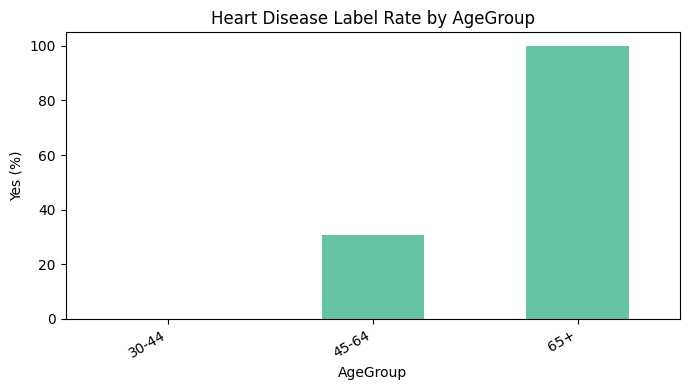

In [7]:

############################################################
# STEP 6: LABEL-BIAS CHECK (Bevor wir überhaupt ein Modell trainieren)
############################################################
# Wir prüfen: sind die GROUND TRUTH Labels schon ungleich verteilt?
# (Das ist oft der Ursprung von Bias in ML)

def label_rate_by_group(data, group_col, label_col="HeartDiseaseLabel"):
    print(f"\n=== LABEL RATE BY {group_col.upper()} ===")
    tab = pd.crosstab(data[group_col], data[label_col], normalize="index") * 100

    # Stabil: sicherstellen dass 0/1 existieren
    for col in [0, 1]:
        if col not in tab.columns:
            tab[col] = 0.0
    tab = tab[[0,1]]

    tab.columns = ["No (%)", "Yes (%)"]
    display(tab.round(1))

    diff = tab["Yes (%)"].max() - tab["Yes (%)"].min()
    print(f"Difference (max-min Yes%): {diff:.1f} percentage points")

    plt.figure(figsize=(7,4))
    tab["Yes (%)"].plot(kind="bar")
    plt.title(f"Heart Disease Label Rate by {group_col}")
    plt.ylabel("Yes (%)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    return tab, diff

label_gender, diff_gender = label_rate_by_group(df_clean, "Gender")
label_eth, diff_eth = label_rate_by_group(df_clean, "Ethnicity")
label_hosp, diff_hosp = label_rate_by_group(df_clean, "Hospital Site")
label_age, diff_age = label_rate_by_group(df_clean, "AgeGroup")



In [9]:

############################################################
# STEP 7: TRAINING DATA PREP (Features + Split)
############################################################
# Jetzt machen wir aus df_clean:
# X = Features
# y = Label

# Features, die wir nutzen
feature_cols = [
    "Age",
    "BMI",
    "Cholesterol_mgdl",
    "BP_Systolic",
    "BP_Diastolic",
    "Gender",
    "Ethnicity",
    "Smoking",
    "Family History",
    "Hospital Site",
    "AgeGroup"
]

X = df_clean[feature_cols].copy()
y = df_clean["HeartDiseaseLabel"].copy()

print("✓ X/y prepared")
print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())


✓ X/y prepared
X shape: (20, 11) y shape: (20,)


,Age,BMI,Cholesterol_mgdl,BP_Systolic,BP_Diastolic,Gender,Ethnicity,Smoking,Family History,Hospital Site,AgeGroup
0,68,30,250.0,150.0,95.0,Male,White,Yes,Yes,A,65+
1,72,29,260.0,155.0,100.0,Male,White,Yes,Yes,A,65+
2,65,28,240.0,148.0,92.0,Male,White,No,Yes,A,65+
3,59,27,215.0,142.0,88.0,Male,White,No,Yes,A,45-64
4,55,25,195.0,135.0,85.0,Female,White,No,No,A,45-64


In [22]:
############################################################
# STEP 4 (KORRIGIERT): CLEANING & FEATURE ENGINEERING
############################################################

df_clean = df.copy()

import re
import numpy as np
import pandas as pd

# 1) Cholesterol -> numeric (robust)
def to_numeric_safe(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # hole erste Zahl aus String
    m = re.findall(r"\d+", s)
    return float(m[0]) if m else np.nan

df_clean["Cholesterol_mgdl"] = df_clean["Cholesterol (mg/dL)"].apply(to_numeric_safe)

# 2) Blood Pressure "150/95" -> systolic/diastolic (robust)
def split_bp(bp):
    if pd.isna(bp):
        return (np.nan, np.nan)
    s = str(bp).strip()
    if "/" not in s:
        return (np.nan, np.nan)
    parts = s.split("/")
    if len(parts) != 2:
        return (np.nan, np.nan)
    try:
        return (float(parts[0]), float(parts[1]))
    except:
        return (np.nan, np.nan)

df_clean["BP_Systolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[0])
df_clean["BP_Diastolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[1])

# 3) Target label -> 1/0
target_col = "Diagnosis (Heart Disease: Yes/No)"
df_clean["HeartDiseaseLabel"] = df_clean[target_col].map({"Yes": 1, "No": 0})

# 4) Strings normalisieren (damit OneHotEncoder sauber läuft)
for col in ["Gender", "Ethnicity", "Smoking", "Family History", "Hospital Site"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip()

# 5) AgeGroup
def age_group(age):
    try:
        age = float(age)
    except:
        return np.nan
    if age < 30:
        return "18-29"
    elif age < 45:
        return "30-44"
    elif age < 65:
        return "45-64"
    else:
        return "65+"

df_clean["AgeGroup"] = df_clean["Age"].apply(age_group)

print("✓ Step 4 done (cleaning + engineered columns)")
display(df_clean.head())############################################################
# STEP 5: BIAS ANALYSE – SYSTEMATISCH & STABIL
############################################################
# Ziel:
# Wir messen NICHT Unterschiede zwischen Menschen.
# Wir messen:
# → Behandelt unser System Gruppen unterschiedlich?
############################################################

def analyze_bias_by_group(
    data: pd.DataFrame,
    group_col: str,
    outcome_col: str,
    name: str,
    positive_value,
    high_threshold: float = 15.0,
    moderate_threshold: float = 7.0
):
    """
    Systematische Bias-Analyse über Gruppen hinweg.

    Erwartung:
    - group_col: kategorial (z.B. Gender, IncomeLevel, Ethnicity)
    - outcome_col: binär (0/1, True/False, Yes/No)
    - positive_value: explizit definierte positive Klasse (z.B. 1)

    Diese Funktion ist absichtlich streng:
    → explizite Entscheidungen sind Teil von Responsible AI
    """

    print(f"\n--- {name.upper()} BY {group_col.upper()} ---")
    print(f"Positive class defined as: {positive_value}\n")

    # 1️⃣ Sicherstellen: Outcome ist 1D Series
    y = data[outcome_col]
    if isinstance(y, pd.DataFrame):
        raise ValueError(
            f"Outcome '{outcome_col}' darf keine DataFrame sein. "
            f"Gib exakt eine Spalte an."
        )

    # 2️⃣ Explizite binäre Ableitung
    outcome_positive = (y == positive_value)

    # 3️⃣ Crosstab (NUR True/False, keine Margins!)
    crosstab = pd.crosstab(
        data[group_col],
        outcome_positive,
        normalize="index"
    ) * 100

    # 4️⃣ Fehlende Spalten ergänzen (stabil!)
    if True not in crosstab.columns:
        crosstab[True] = 0.0
    if False not in crosstab.columns:
        crosstab[False] = 0.0

    crosstab = crosstab[[False, True]]
    crosstab.columns = ["Negative (%)", "Positive (%)"]

    display(crosstab.round(1))

    # 5️⃣ Bias-Metrik
    max_rate = crosstab["Positive (%)"].max()
    min_rate = crosstab["Positive (%)"].min()
    diff = max_rate - min_rate

    print(f"Max Positive Rate: {max_rate:.1f}%")
    print(f"Min Positive Rate: {min_rate:.1f}%")
    print(f"Difference: {diff:.1f} percentage points")

    if diff > high_threshold:
        bias_level = "HIGH"
        print("🚨 SIGNIFICANT BIAS DETECTED")
    elif diff > moderate_threshold:
        bias_level = "MODERATE"
        print("⚠️ MODERATE BIAS")
    else:
        bias_level = "LOW"
        print("✓ MINIMAL BIAS")

    # 6️⃣ Visualisierung
    plt.figure(figsize=(7,4))
    crosstab["Positive (%)"].plot(kind="bar")
    plt.title(f"{name} by {group_col}")
    plt.ylabel("Positive (%)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    return {
        "group": group_col,
        "outcome": outcome_col,
        "positive_value": positive_value,
        "bias_level": bias_level,
        "difference": float(diff),
        "distribution": crosstab
    }


✓ Step 4 done (cleaning + engineered columns)


,Patient ID,Age,Gender,Ethnicity,Cholesterol (mg/dL),Blood Pressure (mmHg),BMI,Smoking,Family History,Hospital Site,Diagnosis (Heart Disease: Yes/No),Cholesterol_mgdl,BP_Systolic,BP_Diastolic,HeartDiseaseLabel,AgeGroup
0,P1,68,Male,White,250,150/95,30,Yes,Yes,A,Yes,250.0,150.0,95.0,1,65+
1,P2,72,Male,White,260,155/100,29,Yes,Yes,A,Yes,260.0,155.0,100.0,1,65+
2,P3,65,Male,White,240,148/92,28,No,Yes,A,Yes,240.0,148.0,92.0,1,65+
3,P4,59,Male,White,215,142/88,27,No,Yes,A,No,215.0,142.0,88.0,0,45-64
4,P5,55,Female,White,195,135/85,25,No,No,A,No,195.0,135.0,85.0,0,45-64



=== LABEL RATE BY GENDER ===


,No (%),Yes (%)
Gender,,
Female,90.0,10.0
Male,20.0,80.0


Difference (max-min Yes%): 70.0 percentage points


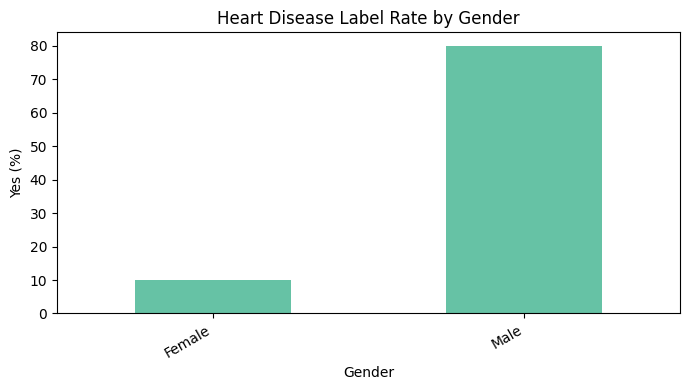


=== LABEL RATE BY ETHNICITY ===


,No (%),Yes (%)
Ethnicity,,
Asian,60.0,40.0
Black,80.0,20.0
Hispanic,25.0,75.0
White,50.0,50.0


Difference (max-min Yes%): 55.0 percentage points


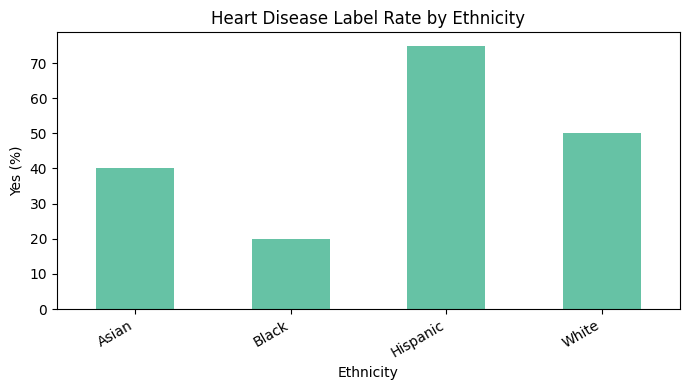


=== LABEL RATE BY HOSPITAL SITE ===


,No (%),Yes (%)
Hospital Site,,
A,50.0,50.0
B,55.6,44.4
C,60.0,40.0


Difference (max-min Yes%): 10.0 percentage points


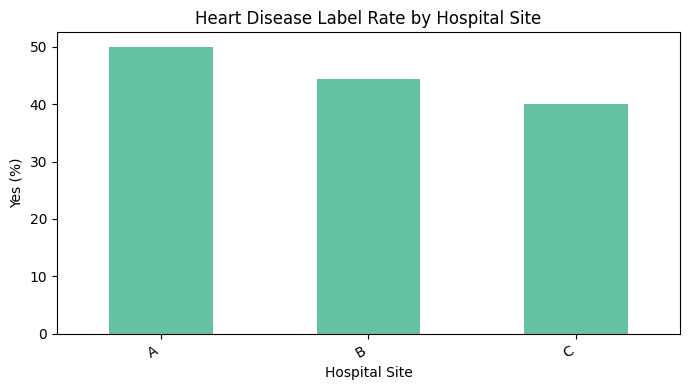


=== LABEL RATE BY AGEGROUP ===


,No (%),Yes (%)
AgeGroup,,
30-44,100.0,0.0
45-64,69.2,30.8
65+,0.0,100.0


Difference (max-min Yes%): 100.0 percentage points


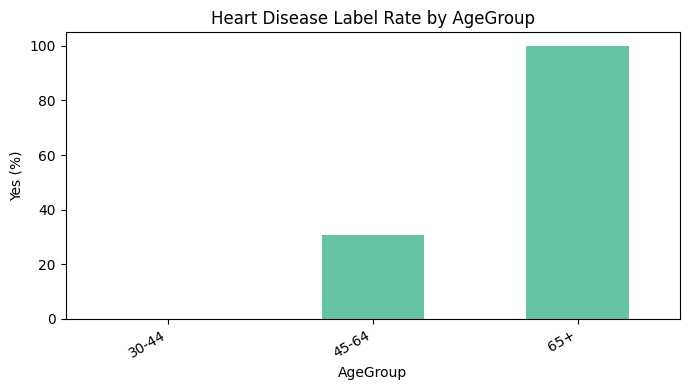

In [23]:
############################################################
# STEP 6: LABEL-BIAS CHECK (Bevor wir überhaupt ein Modell trainieren)
############################################################
# Wir prüfen: sind die GROUND TRUTH Labels schon ungleich verteilt?
# (Das ist oft der Ursprung von Bias in ML)

def label_rate_by_group(data, group_col, label_col="HeartDiseaseLabel"):
    print(f"\n=== LABEL RATE BY {group_col.upper()} ===")
    tab = pd.crosstab(data[group_col], data[label_col], normalize="index") * 100

    # Stabil: sicherstellen dass 0/1 existieren
    for col in [0, 1]:
        if col not in tab.columns:
            tab[col] = 0.0
    tab = tab[[0,1]]

    tab.columns = ["No (%)", "Yes (%)"]
    display(tab.round(1))

    diff = tab["Yes (%)"].max() - tab["Yes (%)"].min()
    print(f"Difference (max-min Yes%): {diff:.1f} percentage points")

    plt.figure(figsize=(7,4))
    tab["Yes (%)"].plot(kind="bar")
    plt.title(f"Heart Disease Label Rate by {group_col}")
    plt.ylabel("Yes (%)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    return tab, diff

label_gender, diff_gender = label_rate_by_group(df_clean, "Gender")
label_eth, diff_eth = label_rate_by_group(df_clean, "Ethnicity")
label_hosp, diff_hosp = label_rate_by_group(df_clean, "Hospital Site")
label_age, diff_age = label_rate_by_group(df_clean, "AgeGroup")






In [24]:
############################################################
# STEP 7: TRAINING DATA PREP (Features + Split)
############################################################
# Jetzt machen wir aus df_clean:
# X = Features
# y = Label

# Features, die wir nutzen
feature_cols = [
    "Age",
    "BMI",
    "Cholesterol_mgdl",
    "BP_Systolic",
    "BP_Diastolic",
    "Gender",
    "Ethnicity",
    "Smoking",
    "Family History",
    "Hospital Site",
    "AgeGroup"
]

X = df_clean[feature_cols].copy()
y = df_clean["HeartDiseaseLabel"].copy()

print("✓ X/y prepared")
print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())

✓ X/y prepared
X shape: (20, 11) y shape: (20,)


,Age,BMI,Cholesterol_mgdl,BP_Systolic,BP_Diastolic,Gender,Ethnicity,Smoking,Family History,Hospital Site,AgeGroup
0,68,30,250.0,150.0,95.0,Male,White,Yes,Yes,A,65+
1,72,29,260.0,155.0,100.0,Male,White,Yes,Yes,A,65+
2,65,28,240.0,148.0,92.0,Male,White,No,Yes,A,65+
3,59,27,215.0,142.0,88.0,Male,White,No,Yes,A,45-64
4,55,25,195.0,135.0,85.0,Female,White,No,No,A,45-64


Training model (with imputation)...

=== MODEL PERFORMANCE (Overall) ===
              precision    recall  f1-score   support

           0      0.750     1.000     0.857         3
           1      1.000     0.667     0.800         3

    accuracy                          0.833         6
   macro avg      0.875     0.833     0.829         6
weighted avg      0.875     0.833     0.829         6



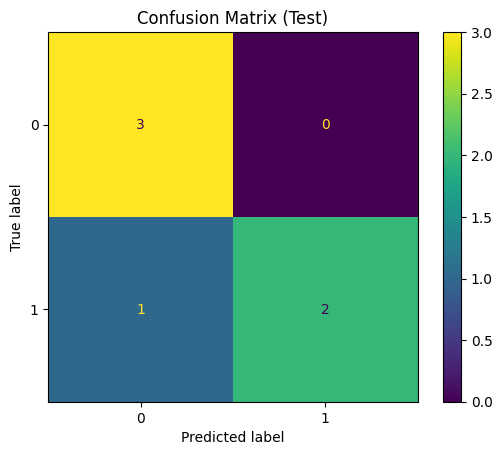

In [26]:
############################################################
# STEP 8 (KORRIGIERT): MODEL TRAINING + Prediction (mit Imputation)
############################################################
# Fix: Imputer in die Pipeline (numerisch + kategorisch)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# Spaltentypen
numeric_features = ["Age", "BMI", "Cholesterol_mgdl", "BP_Systolic", "BP_Diastolic"]
categorical_features = ["Gender", "Ethnicity", "Smoking", "Family History", "Hospital Site", "AgeGroup"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y if y.nunique() > 1 else None
)

# Pipelines für Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # NaNs -> median
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # NaNs -> häufigster Wert
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

print("Training model (with imputation)...")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\n=== MODEL PERFORMANCE (Overall) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test)")
plt.show()


=== PREDICTION RATE BY GENDER ===


,Pred No (%),Pred Yes (%)
Gender,,
Female,100.0,0.0
Male,0.0,100.0


Difference (max-min PredYes%): 100.0 percentage points


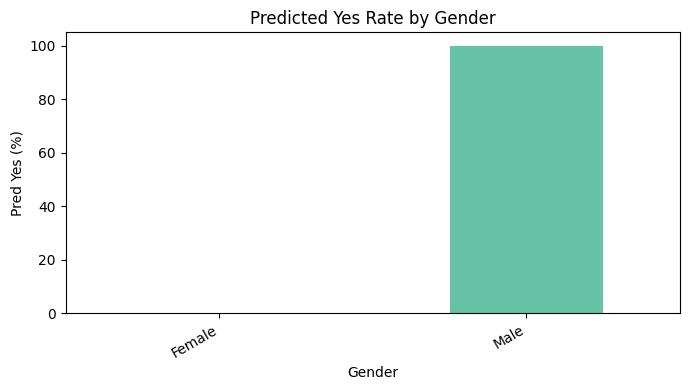


=== PREDICTION RATE BY ETHNICITY ===


,Pred No (%),Pred Yes (%)
Ethnicity,,
Asian,66.7,33.3
Black,50.0,50.0
Hispanic,100.0,0.0


Difference (max-min PredYes%): 50.0 percentage points


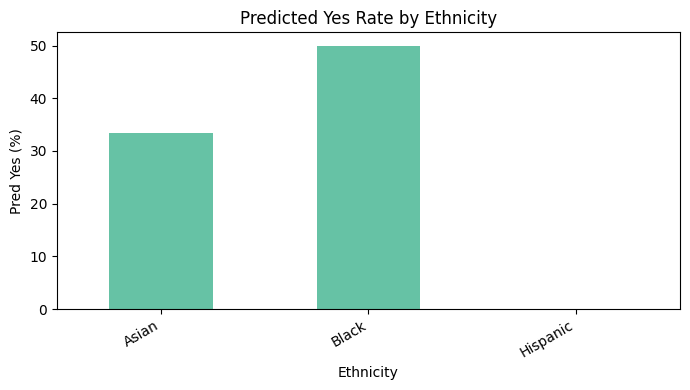


=== PREDICTION RATE BY HOSPITAL SITE ===


,Pred No (%),Pred Yes (%)
Hospital Site,,
B,66.7,33.3
C,66.7,33.3


Difference (max-min PredYes%): 0.0 percentage points


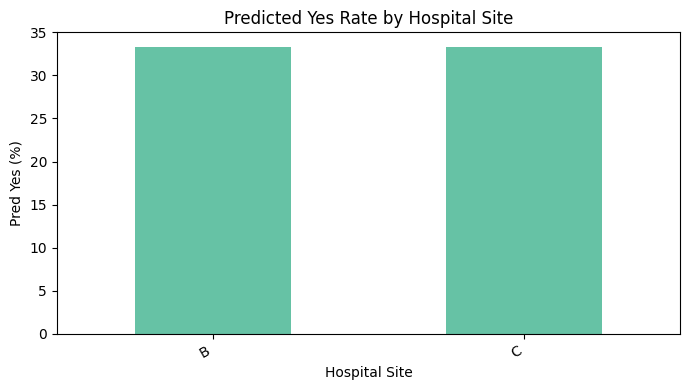


=== PREDICTION RATE BY AGEGROUP ===


,Pred No (%),Pred Yes (%)
AgeGroup,,
45-64,80.0,20.0
65+,0.0,100.0


Difference (max-min PredYes%): 80.0 percentage points


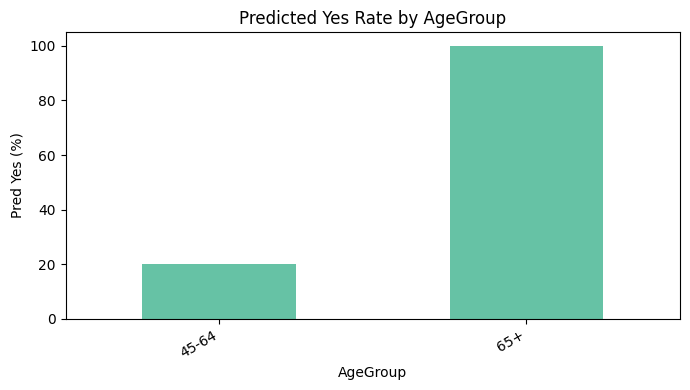

In [27]:


############################################################
# STEP 9: FAIRNESS CHECK AUF PREDICTIONS (Bias im Modell)
############################################################
# Jetzt messen wir NICHT "Menschen sind unterschiedlich",
# sondern:
# "Gibt das Modell systematisch andere Outputs für Gruppen?"

def prediction_rate_by_group(X_test, y_pred, group_col):
    tmp = X_test.copy()
    tmp["Pred"] = y_pred

    print(f"\n=== PREDICTION RATE BY {group_col.upper()} ===")
    tab = pd.crosstab(tmp[group_col], tmp["Pred"], normalize="index") * 100

    for col in [0, 1]:
        if col not in tab.columns:
            tab[col] = 0.0
    tab = tab[[0,1]]
    tab.columns = ["Pred No (%)", "Pred Yes (%)"]
    display(tab.round(1))

    diff = tab["Pred Yes (%)"].max() - tab["Pred Yes (%)"].min()
    print(f"Difference (max-min PredYes%): {diff:.1f} percentage points")

    plt.figure(figsize=(7,4))
    tab["Pred Yes (%)"].plot(kind="bar")
    plt.title(f"Predicted Yes Rate by {group_col}")
    plt.ylabel("Pred Yes (%)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    return tab, diff

pred_gender, pred_diff_gender = prediction_rate_by_group(X_test, y_pred, "Gender")
pred_eth, pred_diff_eth = prediction_rate_by_group(X_test, y_pred, "Ethnicity")
pred_hosp, pred_diff_hosp = prediction_rate_by_group(X_test, y_pred, "Hospital Site")
pred_age, pred_diff_age = prediction_rate_by_group(X_test, y_pred, "AgeGroup")




In [28]:
############################################################
# STEP 10: “CONSTRAINTS” – Entscheidungen in Regeln übersetzen
############################################################
# Das ist der Teil, den viele skippen, aber der eigentlich wichtig ist:
# Du definierst Policy, bevor du “besser trainierst”.

# Beispiel-Policy (Dummy):
# - PredYes-Differenz nach Gender soll <= 10 Prozentpunkte sein
# - PredYes-Differenz nach Ethnicity soll <= 15 Prozentpunkte sein

POLICY = {
    "Gender": 10.0,
    "Ethnicity": 15.0,
    "Hospital Site": 15.0,
    "AgeGroup": 15.0
}

print("\n=== FAIRNESS POLICY CHECK ===")

policy_results = {
    "Gender": pred_diff_gender,
    "Ethnicity": pred_diff_eth,
    "Hospital Site": pred_diff_hosp,
    "AgeGroup": pred_diff_age
}

for group, diff in policy_results.items():
    limit = POLICY[group]
    status = "PASS ✓" if diff <= limit else "FAIL 🚨"
    print(f"{group}: diff={diff:.1f}pp, limit={limit:.1f}pp -> {status}")





=== FAIRNESS POLICY CHECK ===
Gender: diff=100.0pp, limit=10.0pp -> FAIL 🚨
Ethnicity: diff=50.0pp, limit=15.0pp -> FAIL 🚨
Hospital Site: diff=0.0pp, limit=15.0pp -> PASS ✓
AgeGroup: diff=80.0pp, limit=15.0pp -> FAIL 🚨


In [29]:
############################################################
# STEP 11: WAS TUN WENN FAIL? (typische Developer-Aktionen)
############################################################
# Wenn Policy FAIL:
# 1) Datenproblem? -> Sampling / mehr Daten / bessere Features
# 2) Labelproblem? -> Medical process audit / annotation review
# 3) Modellproblem? -> constraints / reweighting / thresholding pro group
#
# Hier: wir zeigen nur eine simple “Reweighting”-Idee als Platzhalter.

print("\n=== NEXT STEPS (Developer Actions) ===")
print("Wenn Bias FAIL ist, machst du NICHT 'einfach anderes Modell'.")
print("Du gehst so vor:")
print("1) Daten prüfen: sind Gruppen underrepresented?")
print("2) Labels prüfen: sind Diagnosen in Gruppen anders dokumentiert?")
print("3) Feature-Leakage prüfen: hat 'Hospital Site' unerwünschten Einfluss?")
print("4) Mit Stakeholdern Policy festlegen: was ist erlaubt?")
print("5) Erst dann: Fairness-Mitigation (Reweighting/Thresholding/etc.)")





=== NEXT STEPS (Developer Actions) ===
Wenn Bias FAIL ist, machst du NICHT 'einfach anderes Modell'.
Du gehst so vor:
1) Daten prüfen: sind Gruppen underrepresented?
2) Labels prüfen: sind Diagnosen in Gruppen anders dokumentiert?
3) Feature-Leakage prüfen: hat 'Hospital Site' unerwünschten Einfluss?
4) Mit Stakeholdern Policy festlegen: was ist erlaubt?
5) Erst dann: Fairness-Mitigation (Reweighting/Thresholding/etc.)


In [30]:
############################################################
# STEP 12: SUMMARY
############################################################

print("\n=== SUMMARY ===")
print("✓ Real dataset loaded")
print("✓ Cleaned & engineered features")
print("✓ Label bias measured (ground truth)")
print("✓ Baseline model trained")
print("✓ Prediction bias measured")
print("✓ Policy check created (PASS/FAIL)")
print("\nIMPORTANT:")
print("This notebook is the bridge between raw data and responsible model training.")



=== SUMMARY ===
✓ Real dataset loaded
✓ Cleaned & engineered features
✓ Label bias measured (ground truth)
✓ Baseline model trained
✓ Prediction bias measured
✓ Policy check created (PASS/FAIL)

IMPORTANT:
This notebook is the bridge between raw data and responsible model training.
